# Reverse sample sequence when an epoch starts

Epoch 1, Loss: 6.5381
Epoch 2, Loss: 4.8429
Epoch 3, Loss: 2.9083
Epoch 4, Loss: 2.1960
Epoch 5, Loss: 1.5070
Epoch 6, Loss: 1.2697
Epoch 7, Loss: 1.0641
Epoch 8, Loss: 0.9846
Epoch 9, Loss: 0.9390
Epoch 10, Loss: 0.9086
Epoch 1, Loss: 5.5809
Epoch 2, Loss: 1.2019
Epoch 3, Loss: 1.6675
Epoch 4, Loss: 3.5144
Epoch 5, Loss: 3.3324
Epoch 6, Loss: 2.0431
Epoch 7, Loss: 2.2132
Epoch 8, Loss: 3.1160
Epoch 9, Loss: 2.9864
Epoch 10, Loss: 2.1811


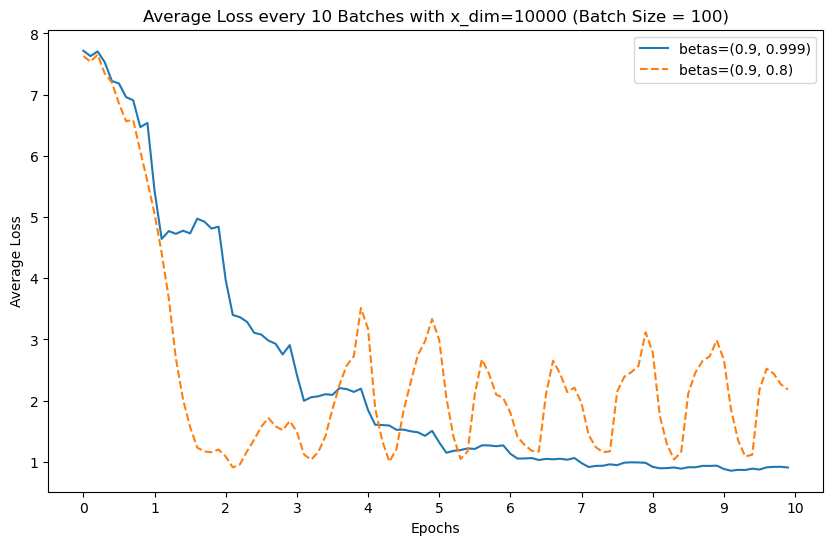

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleRMSprop:
    def __init__(self, lr=0.01, beta=0.9, epsilon=1e-8):
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon
        self.v = 0  # Accumulated gradient squared

    def update(self, grad):
        # Update the accumulated squared gradient
        self.v = self.beta * self.v + (1 - self.beta) * (grad ** 2)
        # Compute the RMSprop update
        return -self.lr * grad / (np.sqrt(self.v) + self.epsilon)
    
class SimpleAdam:
    def __init__(self, lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.m = 0  # First moment
        self.v = 0  # Second moment
        self.t = 0  # Time step

    def update(self, grad):
        self.t += 1
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * grad
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * (grad ** 2)
        m_hat = self.m / (1 - self.beta_1 ** self.t)
        v_hat = self.v / (1 - self.beta_2 ** self.t)
        return -self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

# Define a quadratic function acting on one dimension of x
def quadratic_function(x, coeffs, x_dim_idx):
    return coeffs[0] * (x[x_dim_idx] - coeffs[2])**2 + coeffs[1]

# Gradient of the quadratic function
def gradient_quadratic(x, coeffs, x_dim_idx):
    grad = np.zeros_like(x)
    grad[x_dim_idx] = 2 * coeffs[0] * (x[x_dim_idx] - coeffs[2])
    return grad

# Simulate training with input dimension x_dim and each function depending on one dimension of x
def simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.01, betas=(0.9, 0.999), plot_every=10):
    beta_1 = betas[0]
    beta_2 = betas[1]
    #x = np.random.uniform(-2, 2, size=x_dim)  # Initialize x for all dimensions
    x = 3 * np.ones(x_dim)
    optimizer = SimpleAdam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    
    # Define quadratic functions with a mix of easy and hard examples
    coeffs_list = np.random.uniform(0.5, 1.0, size=(num_functions, 3))  # Coefficients for random functions
    coeffs_list[:, 2] = np.random.uniform(-1, 1, size=num_functions)  # Minima near zero
    
    # Assign each function to act on a random dimension of x
    x_dim_indices = np.random.randint(0, x_dim, size=num_functions)
    
    avg_loss_history = []
    for epoch in range(num_epochs):
        # Reverse the coefficients and indices
        if epoch == 0:
            perm = list(range(num_functions))
        else:
            perm = list(range(num_functions))[::-1]
        coeffs_list = coeffs_list[perm]
        x_dim_indices = x_dim_indices[perm]
        
        accumulated_loss = 0
        for i in range(0, num_functions, batch_size):
            batch_coeffs = coeffs_list[i:i+batch_size]
            batch_dim_indices = x_dim_indices[i:i+batch_size]
            
            # Compute loss for the current batch
            batch_loss = 0
            batch_grad = np.zeros_like(x)
            for coeffs, x_dim_idx in zip(batch_coeffs, batch_dim_indices):
                batch_loss += quadratic_function(x, coeffs, x_dim_idx)
                batch_grad += gradient_quadratic(x, coeffs, x_dim_idx)
            
            # Average loss and gradient across the batch
            batch_loss /= batch_size
            batch_grad /= batch_size
            
            accumulated_loss += batch_loss
            
            # Update x using the optimizer based on batch gradient
            x += optimizer.update(batch_grad)
            
            # After every 'plot_every' batches, record the average loss and reset accumulated loss
            if (i // batch_size + 1) % plot_every == 0:
                avg_loss_history.append(accumulated_loss / plot_every)
                accumulated_loss = 0
        
        # Record the loss at the end of each epoch
        print(f'Epoch {epoch+1}, Loss: {avg_loss_history[-1]:.4f}')
    
    return avg_loss_history

# Set the parameters for the simulation
num_epochs = 10
batch_size = 100
num_functions = 10000  # Total number of quadratic functions
x_dim = 10000  # Dimensionality of input vector x
plot_every = 10  # Plot average loss every 10 batches
# Simulate training with two different beta_2 values
betas_1 = (0.9, 0.999)
betas_2 = (0.9, 0.8)
loss_history_betas_1 = simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.06, betas=betas_1, plot_every=plot_every)
loss_history_betas_2 = simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.06, betas =betas_2, plot_every=plot_every)

# Plot the average loss history every 'plot_every' batches
t = np.arange(len(loss_history_betas_1))
t = t / (num_functions / batch_size / plot_every)
t_ticks = np.arange(0, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(t, loss_history_betas_1, label=f'betas=({betas_1[0]}, {betas_1[1]})', linestyle='-')
plt.plot(t, loss_history_betas_2, label=f'betas=({betas_2[0]}, {betas_2[1]})', linestyle='--')
plt.gca().set_xticks(t_ticks)
plt.xlabel(f'Epochs')
plt.ylabel('Average Loss')
plt.title(f'Average Loss every {plot_every} Batches with x_dim={x_dim} (Batch Size = {batch_size})')
plt.legend()
plt.show()

# Sample with replacement

Epoch 1, Loss: 5.6637
Epoch 2, Loss: 3.8320
Epoch 3, Loss: 2.6630
Epoch 4, Loss: 1.8497
Epoch 5, Loss: 1.4534
Epoch 6, Loss: 1.1751
Epoch 7, Loss: 1.0356
Epoch 8, Loss: 0.9622
Epoch 9, Loss: 0.9230
Epoch 10, Loss: 0.9007
Epoch 1, Loss: 4.7273
Epoch 2, Loss: 2.0707
Epoch 3, Loss: 1.7253
Epoch 4, Loss: 1.7483
Epoch 5, Loss: 1.6946
Epoch 6, Loss: 1.7160
Epoch 7, Loss: 1.6382
Epoch 8, Loss: 1.6537
Epoch 9, Loss: 1.6388
Epoch 10, Loss: 1.6589


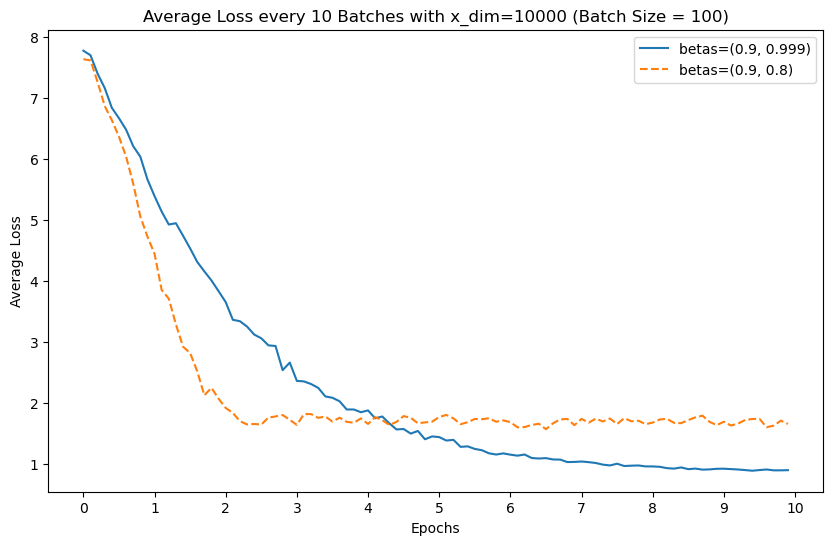

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random

class SimpleRMSprop:
    def __init__(self, lr=0.01, beta=0.9, epsilon=1e-8):
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon
        self.v = 0  # Accumulated gradient squared

    def update(self, grad):
        # Update the accumulated squared gradient
        self.v = self.beta * self.v + (1 - self.beta) * (grad ** 2)
        # Compute the RMSprop update
        return -self.lr * grad / (np.sqrt(self.v) + self.epsilon)
    
class SimpleAdam:
    def __init__(self, lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.m = 0  # First moment
        self.v = 0  # Second moment
        self.t = 0  # Time step

    def update(self, grad):
        self.t += 1
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * grad
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * (grad ** 2)
        m_hat = self.m / (1 - self.beta_1 ** self.t)
        v_hat = self.v / (1 - self.beta_2 ** self.t)
        return -self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

# Define a quadratic function acting on one dimension of x
def quadratic_function(x, coeffs, x_dim_idx):
    return coeffs[0] * (x[x_dim_idx] - coeffs[2])**2 + coeffs[1]

# Gradient of the quadratic function
def gradient_quadratic(x, coeffs, x_dim_idx):
    grad = np.zeros_like(x)
    grad[x_dim_idx] = 2 * coeffs[0] * (x[x_dim_idx] - coeffs[2])
    return grad

# Simulate training with input dimension x_dim and each function depending on one dimension of x
def simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.01, betas=(0.9, 0.999), plot_every=10):
    beta_1 = betas[0]
    beta_2 = betas[1]
    #x = np.random.uniform(-2, 2, size=x_dim)  # Initialize x for all dimensions
    x = 3 * np.ones(x_dim)
    optimizer = SimpleAdam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    
    # Define quadratic functions with a mix of easy and hard examples
    coeffs_list = np.random.uniform(0.5, 1.0, size=(num_functions, 3))  # Coefficients for random functions
    coeffs_list[:, 2] = np.random.uniform(-1, 1, size=num_functions)  # Minima near zero
    
    # Assign each function to act on a random dimension of x
    x_dim_indices = np.random.randint(0, x_dim, size=num_functions)
    index_list = list(range(num_functions))
    
    avg_loss_history = []
    for epoch in range(num_epochs):
        accumulated_loss = 0
        for i in range(0, num_functions, batch_size):
            batch_index_list = random.sample(index_list, batch_size) 
            batch_coeffs = coeffs_list[batch_index_list]
            batch_dim_indices = x_dim_indices[batch_index_list]
            
            # Compute loss for the current batch
            batch_loss = 0
            batch_grad = np.zeros_like(x)
            for coeffs, x_dim_idx in zip(batch_coeffs, batch_dim_indices):
                batch_loss += quadratic_function(x, coeffs, x_dim_idx)
                batch_grad += gradient_quadratic(x, coeffs, x_dim_idx)
            
            # Average loss and gradient across the batch
            batch_loss /= batch_size
            batch_grad /= batch_size
            
            accumulated_loss += batch_loss
            
            # Update x using the optimizer based on batch gradient
            x += optimizer.update(batch_grad)
            
            # After every 'plot_every' batches, record the average loss and reset accumulated loss
            if (i // batch_size + 1) % plot_every == 0:
                avg_loss_history.append(accumulated_loss / plot_every)
                accumulated_loss = 0
        
        # Record the loss at the end of each epoch
        print(f'Epoch {epoch+1}, Loss: {avg_loss_history[-1]:.4f}')
    
    return avg_loss_history

# Set the parameters for the simulation
num_epochs = 10
batch_size = 100
num_functions = 10000  # Total number of quadratic functions
x_dim = 10000  # Dimensionality of input vector x
plot_every = 10  # Plot average loss every 10 batches
# Simulate training with two different beta_2 values
betas_1 = (0.9, 0.999)
betas_2 = (0.9, 0.8)
loss_history_betas_1 = simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.06, betas=betas_1, plot_every=plot_every)
loss_history_betas_2 = simulate_training(num_epochs, batch_size, num_functions, x_dim, lr=0.06, betas =betas_2, plot_every=plot_every)

# Plot the average loss history every 'plot_every' batches
t = np.arange(len(loss_history_betas_1))
t = t / (num_functions / batch_size / plot_every)
t_ticks = np.arange(0, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(t, loss_history_betas_1, label=f'betas=({betas_1[0]}, {betas_1[1]})', linestyle='-')
plt.plot(t, loss_history_betas_2, label=f'betas=({betas_2[0]}, {betas_2[1]})', linestyle='--')
plt.gca().set_xticks(t_ticks)
plt.xlabel(f'Epochs')
plt.ylabel('Average Loss')
plt.title(f'Average Loss every {plot_every} Batches with x_dim={x_dim} (Batch Size = {batch_size})')
plt.legend()
plt.show()